# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Convert a model

In [3]:
import numpy
from skl2onnx import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.


## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.9999"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.38238996267318726
      floats: 1.387866735458374
      floats: -2.1189470291137695
      floats: -0.9714259505271912
      floats: 0.5414416193962097
      floats: -1.6170357465744019
      floats: 0.39679303765296936
      floats: -1.149908423423767
      floats: -1.5385243892669678
      floats: -1.4726897478103638
      floats: 2.333249807357788
      floats: 2.149620771408081
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.24709808826446533
      floats: 0.6978977918624878
      floats: -0.9166491627693176
      type: F

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  ranksep=0.25;
  nodesep=0.05;
  orientation=portrait;

  X [shape=box color=red label="X\nfloat((1, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((1,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.38238996  1.38...\nintercepts=[ 0.24709809  0.6978...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

## runtime

Let's compute the prediction using a Python runtime.

In [8]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

[{0: 0.004945931230060537, 1: 0.2975278599159528, 2: 0.6975262088539865},
 {0: 0.001097307209673002, 1: 0.21864200269994002, 2: 0.780260690090387},
 {0: 0.8126892198504229, 1: 0.1870878713863503, 2: 0.00022290876322689126},
 {0: 0.04088627691198956, 1: 0.4575907757758892, 2: 0.5015229473121213},
 {0: 0.0005940552971759367, 1: 0.40686373628090544, 2: 0.5925422084219186}]

In [9]:
import pandas
prob = pandas.DataFrame(prob).values
prob[:5]

array([[4.94593123e-03, 2.97527860e-01, 6.97526209e-01],
       [1.09730721e-03, 2.18642003e-01, 7.80260690e-01],
       [8.12689220e-01, 1.87087871e-01, 2.22908763e-04],
       [4.08862769e-02, 4.57590776e-01, 5.01522947e-01],
       [5.94055297e-04, 4.06863736e-01, 5.92542208e-01]])

Which we compare to the original model.

In [10]:
clr.predict_proba(X_test)[:5]

array([[4.94593311e-03, 2.97527889e-01, 6.97526178e-01],
       [1.09730767e-03, 2.18642025e-01, 7.80260668e-01],
       [8.12689226e-01, 1.87087865e-01, 2.22908754e-04],
       [4.08862888e-02, 4.57590805e-01, 5.01522906e-01],
       [5.94055535e-04, 4.06863756e-01, 5.92542189e-01]])

Some time measurement...

In [11]:
%timeit clr.predict_proba(X_test)

80.2 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit sess.run({'X': X_test})['output_probability']

172 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With one observation:

In [13]:
%timeit clr.predict_proba(X_test[:1])

72.3 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

46.2 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%matplotlib inline

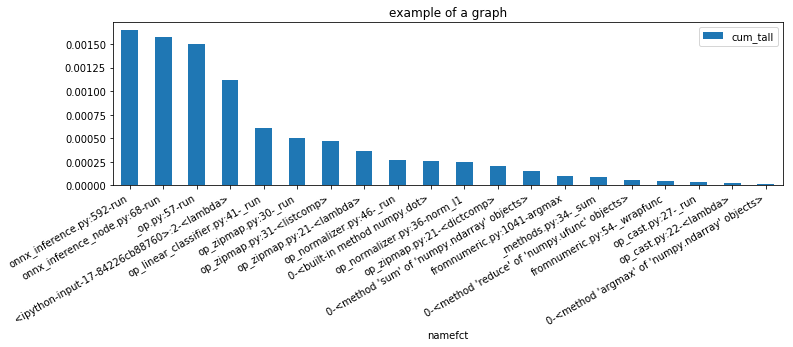

In [16]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');